In [73]:
# #%%
# from os import walk
# import os.path
# import re

# import pandas as pd
# import numpy as np
# from scipy import signal
# import matplotlib.pyplot as plt
# from math import sqrt
# from scipy.stats import kurtosis
# import samplerate
# import matplotlib as mpl
# from matplotlib import gridspec
# import matplotlib as mpl
# import os

# from PIL import Image

# # konfiguracja
# verbose = True
# regen_intermediate = False
# small_run = True # testy tylko na kilku plikach

# test_files = [
#     # 'brak_gaz_k_01_', 
#     # 'brak_k_01_',
#      'zabr_olej_k_01_',
#     # 'zmiana_U_d_01_',
# ]

# path_data = r".\data\RAW"
# path_photo = r".\tex\photo"
# path_interm = r".\data\interm"
# path_tex = r".\tex"
# path_texinput = r""
# path_texinterm = r".\tex"
# ext_P = "4.txt"
# ext_U = "1.txt"
# ext_I = "0.txt"
# ext_G = "3.txt"

# N_ord = 4 # rząd filtra
# obcfreq = [16, 31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]
# fs_raw = 250e+3
# fs = 50e+3
# resample_ratio = fs/fs_raw
# ws = 2048 # szerokoś okna w samplach
# ol = 0.25 # zakładka okna <0:1)

# statf = [
#     lambda w: kurtosis(w), # kurt
#     lambda w: entropy(w),
#     lambda w: beta_a(w),
#     lambda w: beta_b(w),
#     # lambda w: # rice freq
# ]

# #%%
# def entropy(X, lower=-1, upper=1, nbins=2048):
#     Xhist = np.zeros(nbins)
#     Xhist, _ = np.histogram(X.transpose(), bins=nbins, range=(lower, upper))
#     Xhist = Xhist / sum(Xhist)
#     return - np.sum(np.nan_to_num(Xhist * np.log10(Xhist)))

# def beta_a(w):
#     m = w.mean()
#     v = w.var()
#     if m == 0 and v == 0:
#         return 0
#     else:
#         return (m * (1 - m) / v - 1) * m

# def beta_b(w):
#     m = w.mean()
#     v = w.var()
#     if m == 0 and v == 0:
#         return 0
#     else:
#         return (m * (1 - m) / v - 1) * (1 - m)

# # definicje funkcji
# def _showfilter(sos, freq, fs, ax):
#     wn = 8192
#     w = np.zeros([wn])
#     h = np.zeros([wn], dtype=np.complex_)

#     w[:], h[:] = signal.sosfreqz(
#         sos,
#         worN=wn,
#         whole=False,
#         fs=fs
#     )

#     ax.semilogx(w, 20 * np.log10(abs(h) + np.finfo(float).eps), 'b')
#     ax.grid(which='major')
#     ax.grid(which='minor', linestyle=':')
#     ax.set_xlabel(r'Frequency [Hz]')
#     ax.set_ylabel('Amplitude [dB]')
#     ax.set_title('Second-Order Sections - Butterworth Filter')
#     plt.xlim(8, 32000)
#     plt.ylim(-20, 1)
#     ax.set_xticks([16, 31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])
#     ax.set_xticklabels(['16', '31.5', '63', '125', '250', '500',
#                         '1k', '2k', '4k', '8k', '16k'])


# def buffer(X = np.array([]), n = 1, p = 0):
#     # based on function from https://stackoverflow.com/a/57491913
#     #buffers data vector X into length n column vectors with overlap p
#     #excess data at the end of X is discarded
#     n = int(n) #length of each data vector
#     p = int(p) #overlap of data vectors, 0 <= p < n-1
#     L = len(X) #length of data to be buffered
#     m = int(np.floor((L-n)/(n-p)) + 1) #number of sample vectors (no padding)
#     data = np.zeros([n,m]) #initialize data matrix
#     startIndexes = range(0,L-n,n-p)
#     columns = range(0,m)
#     for startIndex,column in zip(startIndexes, columns):
#         data[:,column] = X[startIndex:startIndex + n] #fill in by column
#     return data, np.array(startIndexes)


# # jedziemy...

# # zbierz nazwy plików i ekstrachuj początki
# if small_run:
#     files = test_files
# else:
#     (_, _,  files) = next(walk(path_data))
#     files = [re.split('[0-4].txt$', f)[0] for f in files]
#     files = list(set(files))
# #%%

# for fn in files:
#     if verbose:
#         print(f"przetwarzany plik: {fn}")
    
#     # zassij dane do dataframów
#     picklename = os.path.join(path_interm, fn + ".pkl")

#     if not os.path.exists(picklename) or regen_intermediate:
#         df = pd.read_csv(os.path.join(path_data, fn + ext_P), names=["p"], header=None)
#         df['U'] = pd.read_csv(os.path.join(path_data, fn + ext_U), names=["U"], header=None)
#         df['I'] = pd.read_csv(os.path.join(path_data, fn + ext_I), names=["I"], header=None)
#         if os.path.exists(os.path.join(path_data, fn + ext_G)):
#             df['G'] = pd.read_csv(os.path.join(path_data, fn + ext_G), names=["G"], header=None)

#         # wstępny downsampling
#         data_np = df.to_numpy()
#         data_np = samplerate.resample(data_np, resample_ratio, converter_type='sinc_best', verbose=verbose)
#         df = pd.DataFrame(data_np, columns=df.columns)

#         df['t'] = df.index.values / fs
#         df = df.set_index('t')
#         if verbose:
#             print(f"pikluję downsamplowane sygnały jako: {picklename}")
#         df.to_pickle(picklename)
#     else:
#         if verbose:
#                 print(f"ładuję intermed. z dysku: {picklename}")
#         df = pd.read_pickle(picklename)

#     # obróbka wykresów pomocniczych - napięcie
#     V = df['U'].to_numpy()
#     V = np.hstack([np.zeros((int(np.floor(ws/2)))), V])
#     m = int(np.floor((np.size(V)-ws)/(ws*(1-ol))) + 1) #liczba okien
#     Vbuf, _ = buffer(V, ws, ws*ol)
#     nbins = 128
#     Vhist = np.zeros((nbins, m))
#     histminmax = (V.min(), V.max())
#     for i in range(m):
#         Vhist[:, i], _ = np.histogram(Vbuf[:,i], bins=nbins, range=histminmax)
#     V_hist_plot_max_intensity_ms = Vhist.max() / fs * 1000 * (1-ol)
#     Vhist = (Vhist-Vhist.min(0))/(Vhist.max(0)-Vhist.min(0))
#     mpl.image.imsave(os.path.join(path_texinterm, f"{fn}V.png"), np.flipud(Vhist), cmap='gray_r' )

#     # downsampling prądu aby dało się go odczytać na wykresie
#     data_np = df['I'].to_numpy()
#     data_np = samplerate.resample(data_np, 0.02, converter_type='sinc_best', verbose=verbose)
#     data_np = samplerate.resample(data_np, 0.1, converter_type='sinc_best', verbose=verbose)
#     pd.DataFrame(data_np, index=np.linspace(0, len(data_np)/fs/0.02/0.1, len(data_np)) ).to_csv(
#         os.path.join(path_texinterm, f"{fn}I.csv"), header=None)
#     I_max = data_np.max()
    
#     # generowanie filtrów jako systemów 2. rzędu i filtracja
#     X = df['p'].to_numpy()
#     Xob = np.zeros((len(X), len(obcfreq)))

#     for oct in range(len(obcfreq)):
#         bwf = signal.butter(
#             N=N_ord, 
#             Wn=np.array([obcfreq[oct]/sqrt(2), obcfreq[oct]*sqrt(2)]) / (fs / 2) ,
#             btype='bandpass',
#             analog=False,
#             output='sos' )
#         # if verbose:
#         #     _showfilter(bwf, obcfreq[oct], fs, ax)
        
#         Xob[:, oct] = signal.sosfilt(bwf, X)

#     # half-window 0 padding before stats calculation to align stats with other variables
#     Xob = np.vstack([np.zeros((int(np.floor(ws/2)), np.shape(Xob)[1])), Xob])    
#     # generowanie wartości cech
#     m = int(np.floor((np.size(Xob, 0)-ws)/(ws*(1-ol))) + 1) #liczba okien
#     #Y shape: (m windows, oct octaves, statf statistics)
#     Y = np.zeros((m, len(obcfreq), len(statf)))
    
#     # generowanie statystyk
#     for ioct in range(len(obcfreq)):
#         if verbose:
#             print(f"processing {obcfreq[ioct]}Hz band")
#         Xbuf, centralsamps = buffer(Xob[:, ioct], ws, ws*ol)
#         for isf in range(len(statf)):
#             for iwin in range(m):
#                 Y[iwin, ioct, isf] = (statf[isf])(Xbuf[:, iwin])

# #     # exporting calculated stat data as color mapped matrices
# #     Y_minmax = []
# #     for isf in range(len(statf)):
# #         Y_minmax.append( (Y[:,:,isf].min(), Y[:,:,isf].max()) )
# #         if not isf == 1:
# #             Y[:,:,isf] = (Y[:,:,isf]-Y[:,:,isf].min(0))/(Y[:,:,isf].max(0)-Y[:,:,isf].min(0))
# #         mpl.image.imsave(os.path.join(path_texinterm, f"{fn}{isf}.png"), np.flipud(Y[:,:,isf].transpose()), cmap='viridis' )

# #     # generowanie strony w texu
# #     if verbose:
# #         print("generuję plik wejściowy tex")
# #     xmax = len(X) / fs
# #     plot_width_cm = 23

# #     tex = ""
# #     tex += r'''
# #         \documentclass{article} 
# #         \usepackage[utf8]{inputenc}
# #         \usepackage[a4paper, margin=1.5cm]{geometry}
# #         \usepackage{pgfplots}
# #         \pgfplotsset{compat=1.17}
# #         \usetikzlibrary{pgfplots.groupplots}
# #         \usepackage{pdflscape}
# #         \usepackage{xcolor}
# #         \pgfplotsset{
# #             colormap={blackwhite}{gray(0cm)=(1);gray(1cm)=(0)}
# #         }
# #         \pagestyle{empty} 
# #         \begin{document}
# #         \begin{landscape}
# #         \begin{tikzpicture}
# #         \begin{groupplot}[
# #             group style={
# #                 group name=pp_stack,
# #                 group size=1 by 7,
# #                 xlabels at=edge bottom,
# #                 xticklabels at=edge bottom,
# #                 vertical sep=2pt
# #             },
# #             footnotesize,
# #             '''
# #     tex += f'width={plot_width_cm}cm,'
# #     tex += r'''
# #             height=3.65cm,
# #             xlabel={czas, s},
# #             xmin=0,'''
# #     tex += f' xmax={xmax},'
# #     tex += r'''
# #             ymin=0, 
# #             tickpos=left,
# #             ytick align=outside,
# #             xtick align=outside,
# #             enlargelimits=false,
# #         ]
# #         \nextgroupplot[
# #             ylabel=kurtoza,
# #             ytick={2, 6, 10},
# #             yticklabels={63 Hz, 1 kHz,  16 kHz}, 
# #             colorbar,
# #             colorbar style={
# #         '''
# #     tex += f' point meta min={round(Y_minmax[0][0], 2)},'
# #     tex += r'''
# #         '''
# #     tex += f' point meta max={round(Y_minmax[0][1], 2)},'
# #     tex += r'''
# #         tickpos=right,
# #         colormap name = viridis,
# # 	y tick scale label style={
# #     		at={(yticklabel* cs:1, 20)},
# #     		yshift=-9pt,
# #     		anchor=near yticklabel,
# # 	},
# #             }
# #         ]
# #         \addplot graphics [
# #         xmin=0,'''
# #     tex += f' xmax={xmax},'
# #     tex += r'''
# #             ymin=0, 
# #             ymax=10, ] 
# #             {'''
# #     tex += f'{fn}0.png'
# #     tex += r'''};

# #         \nextgroupplot[
# #             ylabel=entropia,
# #             ytick={2, 6, 10},
# #             yticklabels={63 Hz, 1 kHz,  16 kHz},
# #         colorbar,
# #             colorbar style={
# #         point meta min=0,
# #         point meta max=1,
# #         tickpos=right,
# #         ytick={0.2,0.4,0.6,0.8},
# #         colormap name = viridis,
# # 	y tick scale label style={
# #     		at={(yticklabel* cs:1, 20)},
# #     		yshift=-9pt,
# #     		anchor=near yticklabel,
# # 	},}
# #         ]
# #         \addplot graphics
# #             [xmin=0,'''
# #     tex += f'xmax={xmax},'
# #     tex += r'''
# #             ,ymin=0,
# #             ymax=10] 
# #             {'''
# #     tex += f'{os.path.join(path_texinput, fn + "1.png")}'
# #     tex += r'''};

# #         \nextgroupplot[
# #         ylabel=beta a,
# #             ytick={2, 6, 10},
# #             yticklabels={63 Hz, 1 kHz,  16 kHz},
# #             colorbar,
# #             colorbar style={
# #          '''
# #     tex += f' point meta min={round(Y_minmax[2][0], 2)},'
# #     tex += r'''
# #         '''
# #     tex += f' point meta max={round(Y_minmax[2][1], 2)},'
# #     tex += r'''
# #         tickpos=right,
# #         colormap name = viridis,
# # 	y tick scale label style={
# #     		at={(yticklabel* cs:1, 20)},
# #     		yshift=-9pt,
# #     		anchor=near yticklabel,
# # 	},}
# #         ]
# #         \addplot graphics
# #             [xmin=0,'''
# #     tex += f' xmax={xmax},'
# #     tex += r'''
# #             ,ymin=0
# #             ,ymax=10] 
# #             {'''
# #     tex += f'{os.path.join(path_texinput, fn + "2.png")}'
# #     tex += r'''};

# #         \nextgroupplot[
# #         ylabel=beta b,
# #             ytick={2, 6, 10},
# #             yticklabels={63 Hz, 1 kHz,  16 kHz},
# #         colorbar,
# #             colorbar style={
# #         '''
# #     tex += f' point meta min={round(Y_minmax[3][0], 2)},'
# #     tex += r'''
# #         '''
# #     tex += f' point meta max={round(Y_minmax[3][1], 2)},'
# #     tex += r'''
# #         tickpos=right,
# #         colormap name = viridis,
# # 	y tick scale label style={
# #     		at={(yticklabel* cs:1, 20)},
# #     		yshift=-9pt,
# #     		anchor=near yticklabel,
# # 	},}
# #         ]
# #         \addplot graphics
# #             [xmin=0,'''
# #     tex += f' xmax={xmax},'
# #     tex += r'''
# #             ymin=0,
# #             ymax=10] 
# #             {'''
# #     tex += f'{os.path.join(path_texinput, fn + "3.png")}'
# #     tex += r'''};

# #         \nextgroupplot[
# #             ylabel={U, V; {\color{red} I, A} } ,
# #         colorbar,
# #             colorbar style={
# #         point meta min=0,
# #         point meta max=1,
# #             tickpos=right,
# #         ytick={0.2, 0.8},
# #         '''
# #     tex += f'yticklabels={{{round(0.2*V_hist_plot_max_intensity_ms, 1)}ms, {round(0.8*V_hist_plot_max_intensity_ms, 1)}ms}},'
# #     tex += r'''colormap name = blackwhite},
# # 	y tick scale label style={
# #     		at={(yticklabel* cs:1, 20)},
# #     		yshift=-9pt,
# #     		anchor=near yticklabel,
# # 	},]
    
# #     \addplot graphics
# #             [xmin=0,'''
# #     tex += f' xmax={xmax},'
# #     tex += r'''
# #             ymin=0,
# #             '''
# #     tex += f' ymax={max([histminmax[1], I_max])},'
# #     tex += r'''] 
# #             {'''
# #     tex += f'{os.path.join(path_texinput, fn + "V.png")}'
# #     tex += r'''};
# #         \addplot table [col sep=comma, mark=none] {'''
# #     tex += f'{os.path.join(path_texinput, fn + "I.csv")}'
# #     tex += r'''};'''

# #     # chcemy zachowac aspect ratio
# #     image_ax_height = 0
# #     with Image.open(os.path.join(path_photo, fn + "lico.jpg")) as im:
# #         im_width, im_height = im.size
# #         image_ax_height = plot_width_cm / im_width * im_height

# #     tex += r'''
# #         \nextgroupplot['''
# #     tex += f'height={image_ax_height}cm,'
# #     tex += r'''
# #             ylabel={lico},
# #             ytick = \empty, ]
# #         \addplot graphics  [
# #             xmin=0, '''
# #     tex += f' xmax={xmax},'
# #     tex += r'''
# #             ymin=0,
# #             ymax=1] 
# #             {photo/'''
# #     tex += fn
# #     tex += r'''lico.jpg};
            
# #         \nextgroupplot['''
# #     image_ax_height = 0
# #     with Image.open(os.path.join(path_photo, fn + "gran.jpg")) as im:
# #         im_width, im_height = im.size
# #         image_ax_height = xmax / im_width * im_height
# #     tex += f'height={image_ax_height}cm,'
# #     tex += r'''
# #             ylabel={gran},
# #             ytick = \empty, ]
# #         \addplot graphics  [
# #             xmin=0,'''
# #     tex += f' xmax={xmax},'
# #     tex += r'''
# #             ymin=0,ymax=1] 
# #             {photo/'''
# #     tex += fn
# #     tex += r'''gran.jpg};
# #         '''

# #     tex += r'''
# #         \end{groupplot}
# #         \end{tikzpicture}

# #         \end{landscape}
# #         \end{document}
# #         '''


# #     with open( os.path.join(path_tex, fn+".tex"), 'w') as texfile:
# #         texfile.write(tex)

# #     if verbose:
# #         print(f"plik {fn}.tex gotowy. kompiluję...")

# #     o=os.popen(r'''pdflatex.exe -output-directory=.\tex\ -aux-directory=.\tex\auxy -include-directory=.\tex ''' + fn +'.tex').read()

# #     if verbose:
# #         print(o)
        
# #     print(f'wygenerowano {fn}.pdf')
    

# # end of file loop


Poniżej tylko ładowanie dla każdej osi z 3 różniyc plików: brak zaburzeń

In [74]:
#%%
from os import walk
import os.path
import re

import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import kurtosis
import samplerate
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib as mpl
import os

from PIL import Image

# konfiguracja
verbose = True
regen_intermediate = False
small_run = True # testy tylko na kilku plikach

test_files = [
    # 'brak_gaz_k_01_', 
     'brak_k_01_',
    # 'zabr_olej_k_01_',
    # 'zmiana_U_d_01_',
]

path_data = r".\data\RAW"
path_photo = r".\tex\photo"
path_interm = r".\data\interm"
path_tex = r".\tex"
path_texinput = r""
path_texinterm = r".\tex"
ext_P = "4.txt"
ext_U = "1.txt"
ext_I = "0.txt"
ext_G = "3.txt"

N_ord = 4 # rząd filtra
obcfreq = [16, 31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]
fs_raw = 250e+3
fs = 50e+3
resample_ratio = fs/fs_raw
ws = 2048 # szerokoś okna w samplach
ol = 0.25 # zakładka okna <0:1)

statf = [
    lambda w: kurtosis(w), # kurt
    lambda w: entropy(w),
    lambda w: beta_a(w),
    lambda w: beta_b(w),
    # lambda w: # rice freq
]

#%%
def entropy(X, lower=-1, upper=1, nbins=2048):
    Xhist = np.zeros(nbins)
    Xhist, _ = np.histogram(X.transpose(), bins=nbins, range=(lower, upper))
    Xhist = Xhist / sum(Xhist)
    return - np.sum(np.nan_to_num(Xhist * np.log10(Xhist)))

def beta_a(w):
    m = w.mean()
    v = w.var()
    if m == 0 and v == 0:
        return 0
    else:
        return (m * (1 - m) / v - 1) * m

def beta_b(w):
    m = w.mean()
    v = w.var()
    if m == 0 and v == 0:
        return 0
    else:
        return (m * (1 - m) / v - 1) * (1 - m)

# definicje funkcji
def _showfilter(sos, freq, fs, ax):
    wn = 8192
    w = np.zeros([wn])
    h = np.zeros([wn], dtype=np.complex_)

    w[:], h[:] = signal.sosfreqz(
        sos,
        worN=wn,
        whole=False,
        fs=fs
    )

    ax.semilogx(w, 20 * np.log10(abs(h) + np.finfo(float).eps), 'b')
    ax.grid(which='major')
    ax.grid(which='minor', linestyle=':')
    ax.set_xlabel(r'Frequency [Hz]')
    ax.set_ylabel('Amplitude [dB]')
    ax.set_title('Second-Order Sections - Butterworth Filter')
    plt.xlim(8, 32000)
    plt.ylim(-20, 1)
    ax.set_xticks([16, 31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])
    ax.set_xticklabels(['16', '31.5', '63', '125', '250', '500',
                        '1k', '2k', '4k', '8k', '16k'])


def buffer(X = np.array([]), n = 1, p = 0):
    # based on function from https://stackoverflow.com/a/57491913
    #buffers data vector X into length n column vectors with overlap p
    #excess data at the end of X is discarded
    n = int(n) #length of each data vector
    p = int(p) #overlap of data vectors, 0 <= p < n-1
    L = len(X) #length of data to be buffered
    m = int(np.floor((L-n)/(n-p)) + 1) #number of sample vectors (no padding)
    data = np.zeros([n,m]) #initialize data matrix
    startIndexes = range(0,L-n,n-p)
    columns = range(0,m)
    for startIndex,column in zip(startIndexes, columns):
        data[:,column] = X[startIndex:startIndex + n] #fill in by column
    return data, np.array(startIndexes)


# jedziemy...

# zbierz nazwy plików i ekstrachuj początki
if small_run:
    files = test_files
else:
    (_, _,  files) = next(walk(path_data))
    files = [re.split('[0-4].txt$', f)[0] for f in files]
    files = list(set(files))
#%%

for fn in files:
    if verbose:
        print(f"przetwarzany plik: {fn}")
    
    # zassij dane do dataframów
    picklename = os.path.join(path_interm, fn + ".pkl")

    if not os.path.exists(picklename) or regen_intermediate:
        df = pd.read_csv(os.path.join(path_data, fn + ext_P), names=["p"], header=None)
        df['U'] = pd.read_csv(os.path.join(path_data, fn + ext_U), names=["U"], header=None)
        df['I'] = pd.read_csv(os.path.join(path_data, fn + ext_I), names=["I"], header=None)
        if os.path.exists(os.path.join(path_data, fn + ext_G)):
            df['G'] = pd.read_csv(os.path.join(path_data, fn + ext_G), names=["G"], header=None)

        # wstępny downsampling
        data_np = df.to_numpy()
        data_np = samplerate.resample(data_np, resample_ratio, converter_type='sinc_best', verbose=verbose)
        df = pd.DataFrame(data_np, columns=df.columns)

        df['t'] = df.index.values / fs
        df = df.set_index('t')
        if verbose:
            print(f"pikluję downsamplowane sygnały jako: {picklename}")
        df.to_pickle(picklename)
    else:
        if verbose:
                print(f"ładuję intermed. z dysku: {picklename}")
        df = pd.read_pickle(picklename)

    # obróbka wykresów pomocniczych - napięcie
    V = df['U'].to_numpy()
    V = np.hstack([np.zeros((int(np.floor(ws/2)))), V])
    m = int(np.floor((np.size(V)-ws)/(ws*(1-ol))) + 1) #liczba okien
    Vbuf, _ = buffer(V, ws, ws*ol)
    nbins = 128
    Vhist = np.zeros((nbins, m))
    histminmax = (V.min(), V.max())
    for i in range(m):
        Vhist[:, i], _ = np.histogram(Vbuf[:,i], bins=nbins, range=histminmax)
    V_hist_plot_max_intensity_ms = Vhist.max() / fs * 1000 * (1-ol)
    Vhist = (Vhist-Vhist.min(0))/(Vhist.max(0)-Vhist.min(0))
    mpl.image.imsave(os.path.join(path_texinterm, f"{fn}V.png"), np.flipud(Vhist), cmap='gray_r' )

    # downsampling prądu aby dało się go odczytać na wykresie
    data_np = df['I'].to_numpy()
    data_np = samplerate.resample(data_np, 0.02, converter_type='sinc_best', verbose=verbose)
    data_np = samplerate.resample(data_np, 0.1, converter_type='sinc_best', verbose=verbose)
    pd.DataFrame(data_np, index=np.linspace(0, len(data_np)/fs/0.02/0.1, len(data_np)) ).to_csv(
        os.path.join(path_texinterm, f"{fn}I.csv"), header=None)
    I_max = data_np.max()
    
    # generowanie filtrów jako systemów 2. rzędu i filtracja
    X = df['p'].to_numpy()

przetwarzany plik: brak_k_01_
ładuję intermed. z dysku: .\data\interm\brak_k_01_.pkl
samplerate info:
2050457 input frames used
41009 output frames generated

samplerate info:
41009 input frames used
4100 output frames generated



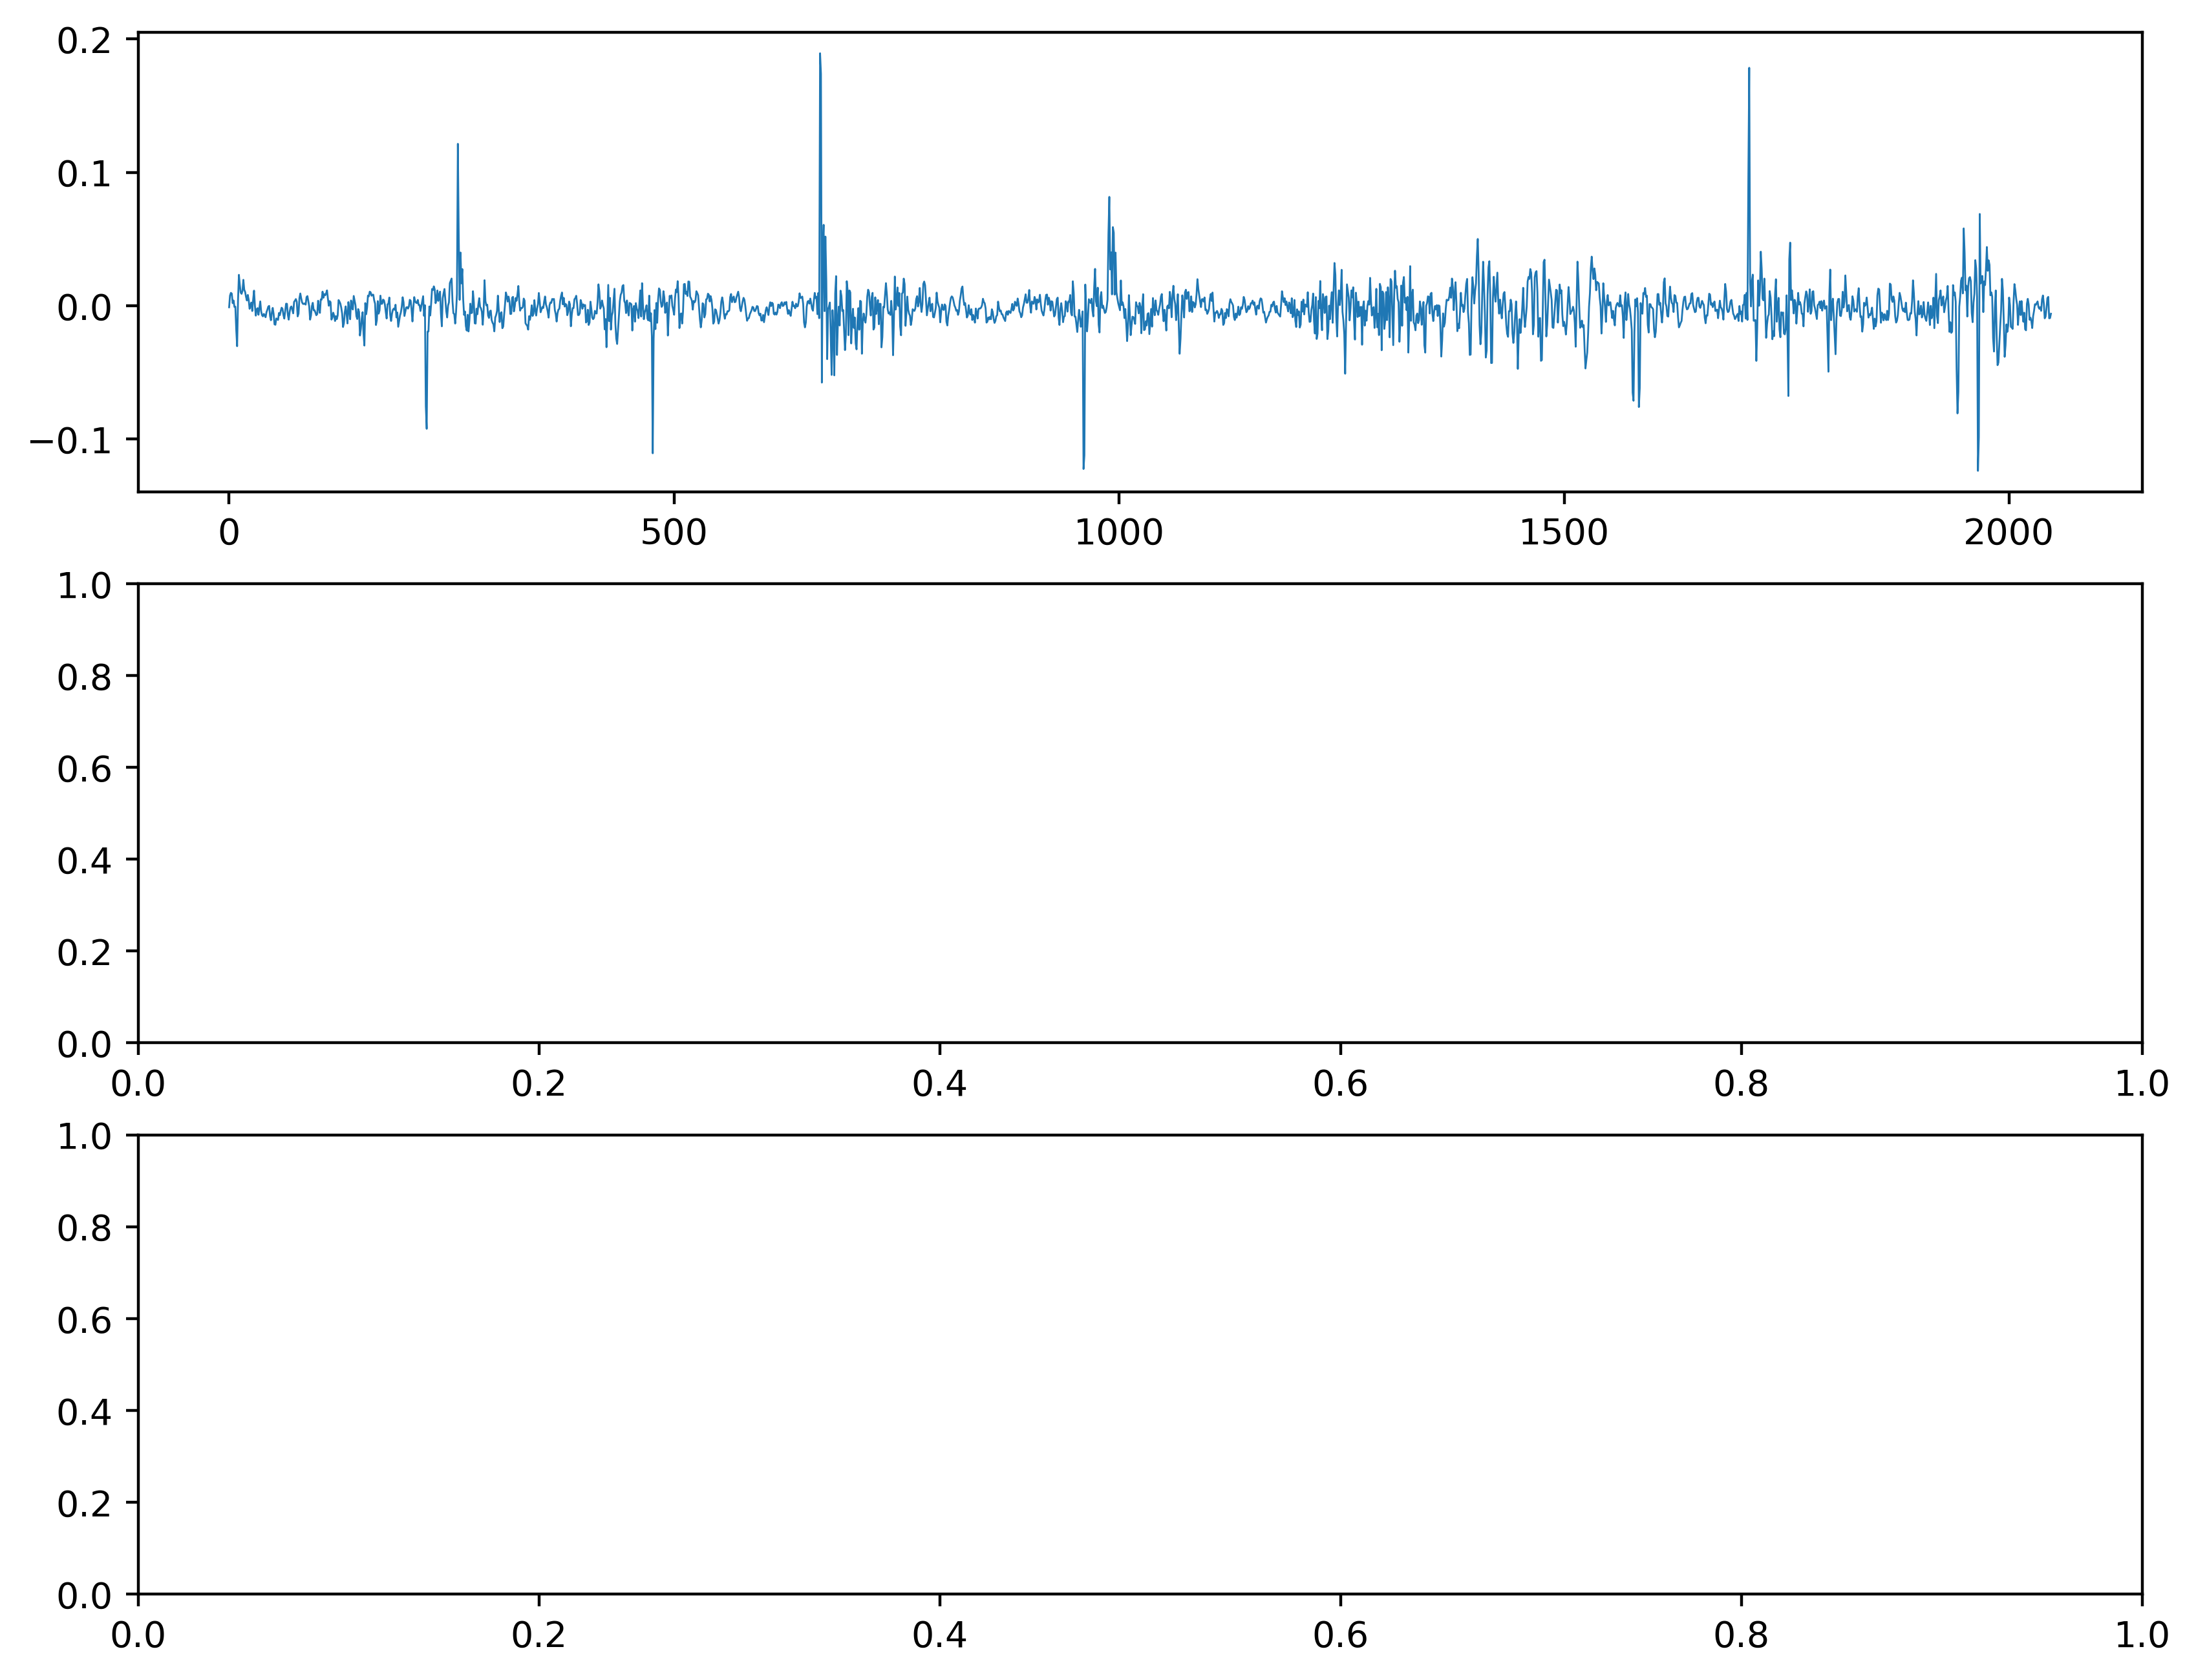

In [75]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), dpi=400)

ax[0].plot(X[10000:12048], linewidth=0.5)

Olej:

In [76]:
#%%
from os import walk
import os.path
import re

import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import kurtosis
import samplerate
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib as mpl
import os

from PIL import Image

# konfiguracja
verbose = True
regen_intermediate = False
small_run = True # testy tylko na kilku plikach

test_files = [
    # 'brak_gaz_k_01_', 
    # 'brak_k_01_',
    'zabr_olej_k_01_',
    # 'zmiana_U_d_01_',
]

path_data = r".\data\RAW"
path_photo = r".\tex\photo"
path_interm = r".\data\interm"
path_tex = r".\tex"
path_texinput = r""
path_texinterm = r".\tex"
ext_P = "4.txt"
ext_U = "1.txt"
ext_I = "0.txt"
ext_G = "3.txt"

N_ord = 4 # rząd filtra
obcfreq = [16, 31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]
fs_raw = 250e+3
fs = 50e+3
resample_ratio = fs/fs_raw
ws = 2048 # szerokoś okna w samplach
ol = 0.25 # zakładka okna <0:1)

statf = [
    lambda w: kurtosis(w), # kurt
    lambda w: entropy(w),
    lambda w: beta_a(w),
    lambda w: beta_b(w),
    # lambda w: # rice freq
]

#%%
def entropy(X, lower=-1, upper=1, nbins=2048):
    Xhist = np.zeros(nbins)
    Xhist, _ = np.histogram(X.transpose(), bins=nbins, range=(lower, upper))
    Xhist = Xhist / sum(Xhist)
    return - np.sum(np.nan_to_num(Xhist * np.log10(Xhist)))

alpha1=mean**2*(1-mean)/var-mean
beta1=alpha1*(1-mean)/mean

def beta_a(w):
    m = w.mean()
    v = w.var()
    if m == 0 and v == 0:
        return 0
    else:
        return (m * (1 - m) / v - 1) * m

def beta_b(w):
    m = w.mean()
    v = w.var()
    if m == 0 and v == 0:
        return 0
    else:
        return (m * (1 - m) / v - 1) * (1 - m)

# definicje funkcji
def _showfilter(sos, freq, fs, ax):
    wn = 8192
    w = np.zeros([wn])
    h = np.zeros([wn], dtype=np.complex_)

    w[:], h[:] = signal.sosfreqz(
        sos,
        worN=wn,
        whole=False,
        fs=fs
    )

    ax.semilogx(w, 20 * np.log10(abs(h) + np.finfo(float).eps), 'b')
    ax.grid(which='major')
    ax.grid(which='minor', linestyle=':')
    ax.set_xlabel(r'Frequency [Hz]')
    ax.set_ylabel('Amplitude [dB]')
    ax.set_title('Second-Order Sections - Butterworth Filter')
    plt.xlim(8, 32000)
    plt.ylim(-20, 1)
    ax.set_xticks([16, 31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])
    ax.set_xticklabels(['16', '31.5', '63', '125', '250', '500',
                        '1k', '2k', '4k', '8k', '16k'])


def buffer(X = np.array([]), n = 1, p = 0):
    # based on function from https://stackoverflow.com/a/57491913
    #buffers data vector X into length n column vectors with overlap p
    #excess data at the end of X is discarded
    n = int(n) #length of each data vector
    p = int(p) #overlap of data vectors, 0 <= p < n-1
    L = len(X) #length of data to be buffered
    m = int(np.floor((L-n)/(n-p)) + 1) #number of sample vectors (no padding)
    data = np.zeros([n,m]) #initialize data matrix
    startIndexes = range(0,L-n,n-p)
    columns = range(0,m)
    for startIndex,column in zip(startIndexes, columns):
        data[:,column] = X[startIndex:startIndex + n] #fill in by column
    return data, np.array(startIndexes)


# jedziemy...

# zbierz nazwy plików i ekstrachuj początki
if small_run:
    files = test_files
else:
    (_, _,  files) = next(walk(path_data))
    files = [re.split('[0-4].txt$', f)[0] for f in files]
    files = list(set(files))
#%%

for fn in files:
    if verbose:
        print(f"przetwarzany plik: {fn}")
    
    # zassij dane do dataframów
    picklename = os.path.join(path_interm, fn + ".pkl")

    if not os.path.exists(picklename) or regen_intermediate:
        df = pd.read_csv(os.path.join(path_data, fn + ext_P), names=["p"], header=None)
        df['U'] = pd.read_csv(os.path.join(path_data, fn + ext_U), names=["U"], header=None)
        df['I'] = pd.read_csv(os.path.join(path_data, fn + ext_I), names=["I"], header=None)
        if os.path.exists(os.path.join(path_data, fn + ext_G)):
            df['G'] = pd.read_csv(os.path.join(path_data, fn + ext_G), names=["G"], header=None)

        # wstępny downsampling
        data_np = df.to_numpy()
        data_np = samplerate.resample(data_np, resample_ratio, converter_type='sinc_best', verbose=verbose)
        df = pd.DataFrame(data_np, columns=df.columns)

        df['t'] = df.index.values / fs
        df = df.set_index('t')
        if verbose:
            print(f"pikluję downsamplowane sygnały jako: {picklename}")
        df.to_pickle(picklename)
    else:
        if verbose:
                print(f"ładuję intermed. z dysku: {picklename}")
        df = pd.read_pickle(picklename)

    # obróbka wykresów pomocniczych - napięcie
    V = df['U'].to_numpy()
    V = np.hstack([np.zeros((int(np.floor(ws/2)))), V])
    m = int(np.floor((np.size(V)-ws)/(ws*(1-ol))) + 1) #liczba okien
    Vbuf, _ = buffer(V, ws, ws*ol)
    nbins = 128
    Vhist = np.zeros((nbins, m))
    histminmax = (V.min(), V.max())
    for i in range(m):
        Vhist[:, i], _ = np.histogram(Vbuf[:,i], bins=nbins, range=histminmax)
    V_hist_plot_max_intensity_ms = Vhist.max() / fs * 1000 * (1-ol)
    Vhist = (Vhist-Vhist.min(0))/(Vhist.max(0)-Vhist.min(0))
    mpl.image.imsave(os.path.join(path_texinterm, f"{fn}V.png"), np.flipud(Vhist), cmap='gray_r' )

    # downsampling prądu aby dało się go odczytać na wykresie
    data_np = df['I'].to_numpy()
    data_np = samplerate.resample(data_np, 0.02, converter_type='sinc_best', verbose=verbose)
    data_np = samplerate.resample(data_np, 0.1, converter_type='sinc_best', verbose=verbose)
    pd.DataFrame(data_np, index=np.linspace(0, len(data_np)/fs/0.02/0.1, len(data_np)) ).to_csv(
        os.path.join(path_texinterm, f"{fn}I.csv"), header=None)
    I_max = data_np.max()
    
    # generowanie filtrów jako systemów 2. rzędu i filtracja
    X = df['p'].to_numpy()

przetwarzany plik: zabr_olej_k_01_
ładuję intermed. z dysku: .\data\interm\zabr_olej_k_01_.pkl
samplerate info:
2350694 input frames used
47013 output frames generated

samplerate info:
47013 input frames used
4701 output frames generated



In [77]:
ax[1].plot(X[int(26*50e+3):int(26*50e+3+2048)], linewidth=0.5)

zmiana napięcia

In [78]:
#%%
from os import walk
import os.path
import re

import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import kurtosis
import samplerate
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib as mpl
import os

from PIL import Image

# konfiguracja
verbose = True
regen_intermediate = False
small_run = True # testy tylko na kilku plikach

test_files = [
    # 'brak_gaz_k_01_', 
    # 'brak_k_01_',
    'zabr_olej_k_01_',
    # 'zmiana_U_d_01_',
]

path_data = r".\data\RAW"
path_photo = r".\tex\photo"
path_interm = r".\data\interm"
path_tex = r".\tex"
path_texinput = r""
path_texinterm = r".\tex"
ext_P = "4.txt"
ext_U = "1.txt"
ext_I = "0.txt"
ext_G = "3.txt"

N_ord = 4 # rząd filtra
obcfreq = [16, 31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]
fs_raw = 250e+3
fs = 50e+3
resample_ratio = fs/fs_raw
ws = 2048 # szerokoś okna w samplach
ol = 0.25 # zakładka okna <0:1)

statf = [
    lambda w: kurtosis(w), # kurt
    lambda w: entropy(w),
    lambda w: beta_a(w),
    lambda w: beta_b(w),
    # lambda w: # rice freq
]

#%%
def entropy(X, lower=-1, upper=1, nbins=2048):
    Xhist = np.zeros(nbins)
    Xhist, _ = np.histogram(X.transpose(), bins=nbins, range=(lower, upper))
    Xhist = Xhist / sum(Xhist)
    return - np.sum(np.nan_to_num(Xhist * np.log10(Xhist)))

def beta_a(w):
    m = w.mean()
    v = w.var()
    if m == 0 and v == 0:
        return 0
    else:
        return (m * (1 - m) / v - 1) * m

def beta_b(w):
    m = w.mean()
    v = w.var()
    if m == 0 and v == 0:
        return 0
    else:
        return (m * (1 - m) / v - 1) * (1 - m)

# definicje funkcji
def _showfilter(sos, freq, fs, ax):
    wn = 8192
    w = np.zeros([wn])
    h = np.zeros([wn], dtype=np.complex_)

    w[:], h[:] = signal.sosfreqz(
        sos,
        worN=wn,
        whole=False,
        fs=fs
    )

    ax.semilogx(w, 20 * np.log10(abs(h) + np.finfo(float).eps), 'b')
    ax.grid(which='major')
    ax.grid(which='minor', linestyle=':')
    ax.set_xlabel(r'Frequency [Hz]')
    ax.set_ylabel('Amplitude [dB]')
    ax.set_title('Second-Order Sections - Butterworth Filter')
    plt.xlim(8, 32000)
    plt.ylim(-20, 1)
    ax.set_xticks([16, 31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])
    ax.set_xticklabels(['16', '31.5', '63', '125', '250', '500',
                        '1k', '2k', '4k', '8k', '16k'])


def buffer(X = np.array([]), n = 1, p = 0):
    # based on function from https://stackoverflow.com/a/57491913
    #buffers data vector X into length n column vectors with overlap p
    #excess data at the end of X is discarded
    n = int(n) #length of each data vector
    p = int(p) #overlap of data vectors, 0 <= p < n-1
    L = len(X) #length of data to be buffered
    m = int(np.floor((L-n)/(n-p)) + 1) #number of sample vectors (no padding)
    data = np.zeros([n,m]) #initialize data matrix
    startIndexes = range(0,L-n,n-p)
    columns = range(0,m)
    for startIndex,column in zip(startIndexes, columns):
        data[:,column] = X[startIndex:startIndex + n] #fill in by column
    return data, np.array(startIndexes)


# jedziemy...

# zbierz nazwy plików i ekstrachuj początki
if small_run:
    files = test_files
else:
    (_, _,  files) = next(walk(path_data))
    files = [re.split('[0-4].txt$', f)[0] for f in files]
    files = list(set(files))
#%%

for fn in files:
    if verbose:
        print(f"przetwarzany plik: {fn}")
    
    # zassij dane do dataframów
    picklename = os.path.join(path_interm, fn + ".pkl")

    if not os.path.exists(picklename) or regen_intermediate:
        df = pd.read_csv(os.path.join(path_data, fn + ext_P), names=["p"], header=None)
        df['U'] = pd.read_csv(os.path.join(path_data, fn + ext_U), names=["U"], header=None)
        df['I'] = pd.read_csv(os.path.join(path_data, fn + ext_I), names=["I"], header=None)
        if os.path.exists(os.path.join(path_data, fn + ext_G)):
            df['G'] = pd.read_csv(os.path.join(path_data, fn + ext_G), names=["G"], header=None)

        # wstępny downsampling
        data_np = df.to_numpy()
        data_np = samplerate.resample(data_np, resample_ratio, converter_type='sinc_best', verbose=verbose)
        df = pd.DataFrame(data_np, columns=df.columns)

        df['t'] = df.index.values / fs
        df = df.set_index('t')
        if verbose:
            print(f"pikluję downsamplowane sygnały jako: {picklename}")
        df.to_pickle(picklename)
    else:
        if verbose:
                print(f"ładuję intermed. z dysku: {picklename}")
        df = pd.read_pickle(picklename)

    # obróbka wykresów pomocniczych - napięcie
    V = df['U'].to_numpy()
    V = np.hstack([np.zeros((int(np.floor(ws/2)))), V])
    m = int(np.floor((np.size(V)-ws)/(ws*(1-ol))) + 1) #liczba okien
    Vbuf, _ = buffer(V, ws, ws*ol)
    nbins = 128
    Vhist = np.zeros((nbins, m))
    histminmax = (V.min(), V.max())
    for i in range(m):
        Vhist[:, i], _ = np.histogram(Vbuf[:,i], bins=nbins, range=histminmax)
    V_hist_plot_max_intensity_ms = Vhist.max() / fs * 1000 * (1-ol)
    Vhist = (Vhist-Vhist.min(0))/(Vhist.max(0)-Vhist.min(0))
    mpl.image.imsave(os.path.join(path_texinterm, f"{fn}V.png"), np.flipud(Vhist), cmap='gray_r' )

    # downsampling prądu aby dało się go odczytać na wykresie
    data_np = df['I'].to_numpy()
    data_np = samplerate.resample(data_np, 0.02, converter_type='sinc_best', verbose=verbose)
    data_np = samplerate.resample(data_np, 0.1, converter_type='sinc_best', verbose=verbose)
    pd.DataFrame(data_np, index=np.linspace(0, len(data_np)/fs/0.02/0.1, len(data_np)) ).to_csv(
        os.path.join(path_texinterm, f"{fn}I.csv"), header=None)
    I_max = data_np.max()
    
    # generowanie filtrów jako systemów 2. rzędu i filtracja
    X = df['p'].to_numpy()

przetwarzany plik: zabr_olej_k_01_
ładuję intermed. z dysku: .\data\interm\zabr_olej_k_01_.pkl
samplerate info:
2350694 input frames used
47013 output frames generated

samplerate info:
47013 input frames used
4701 output frames generated



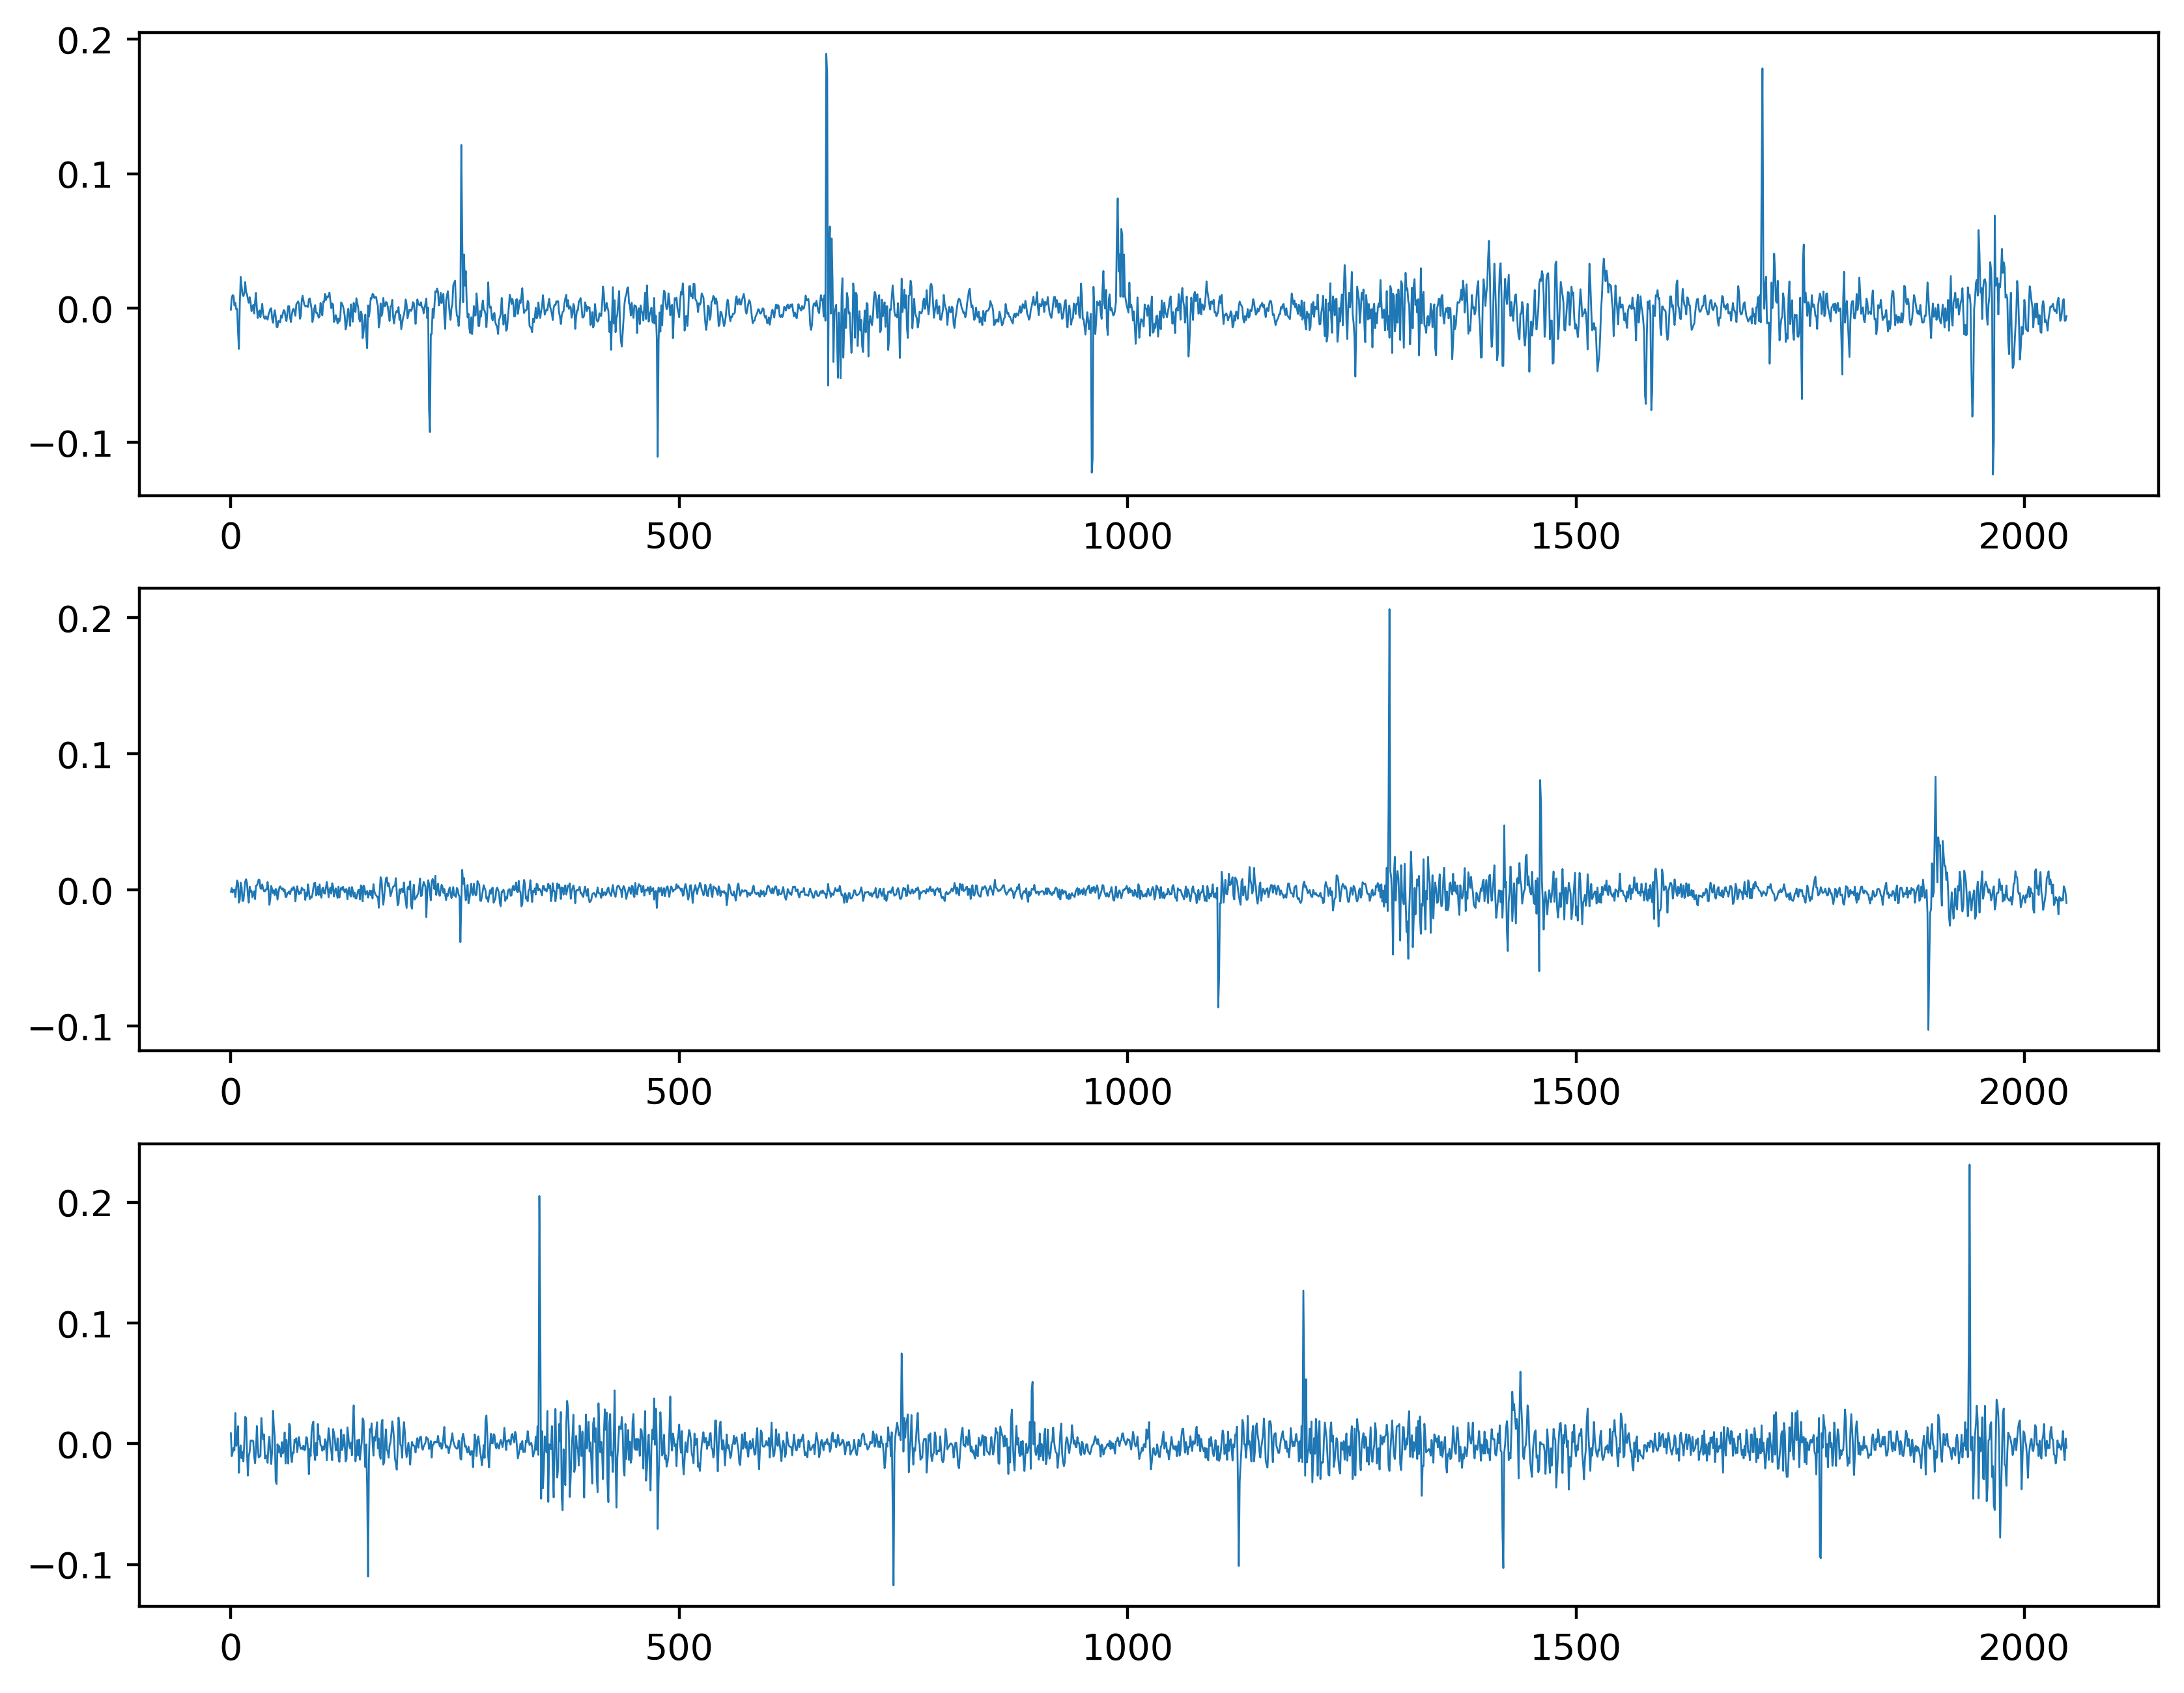

In [79]:
ax[2].plot(X[int(13*50e+3):int(13*50e+3+2048)], linewidth=0.5)
fig

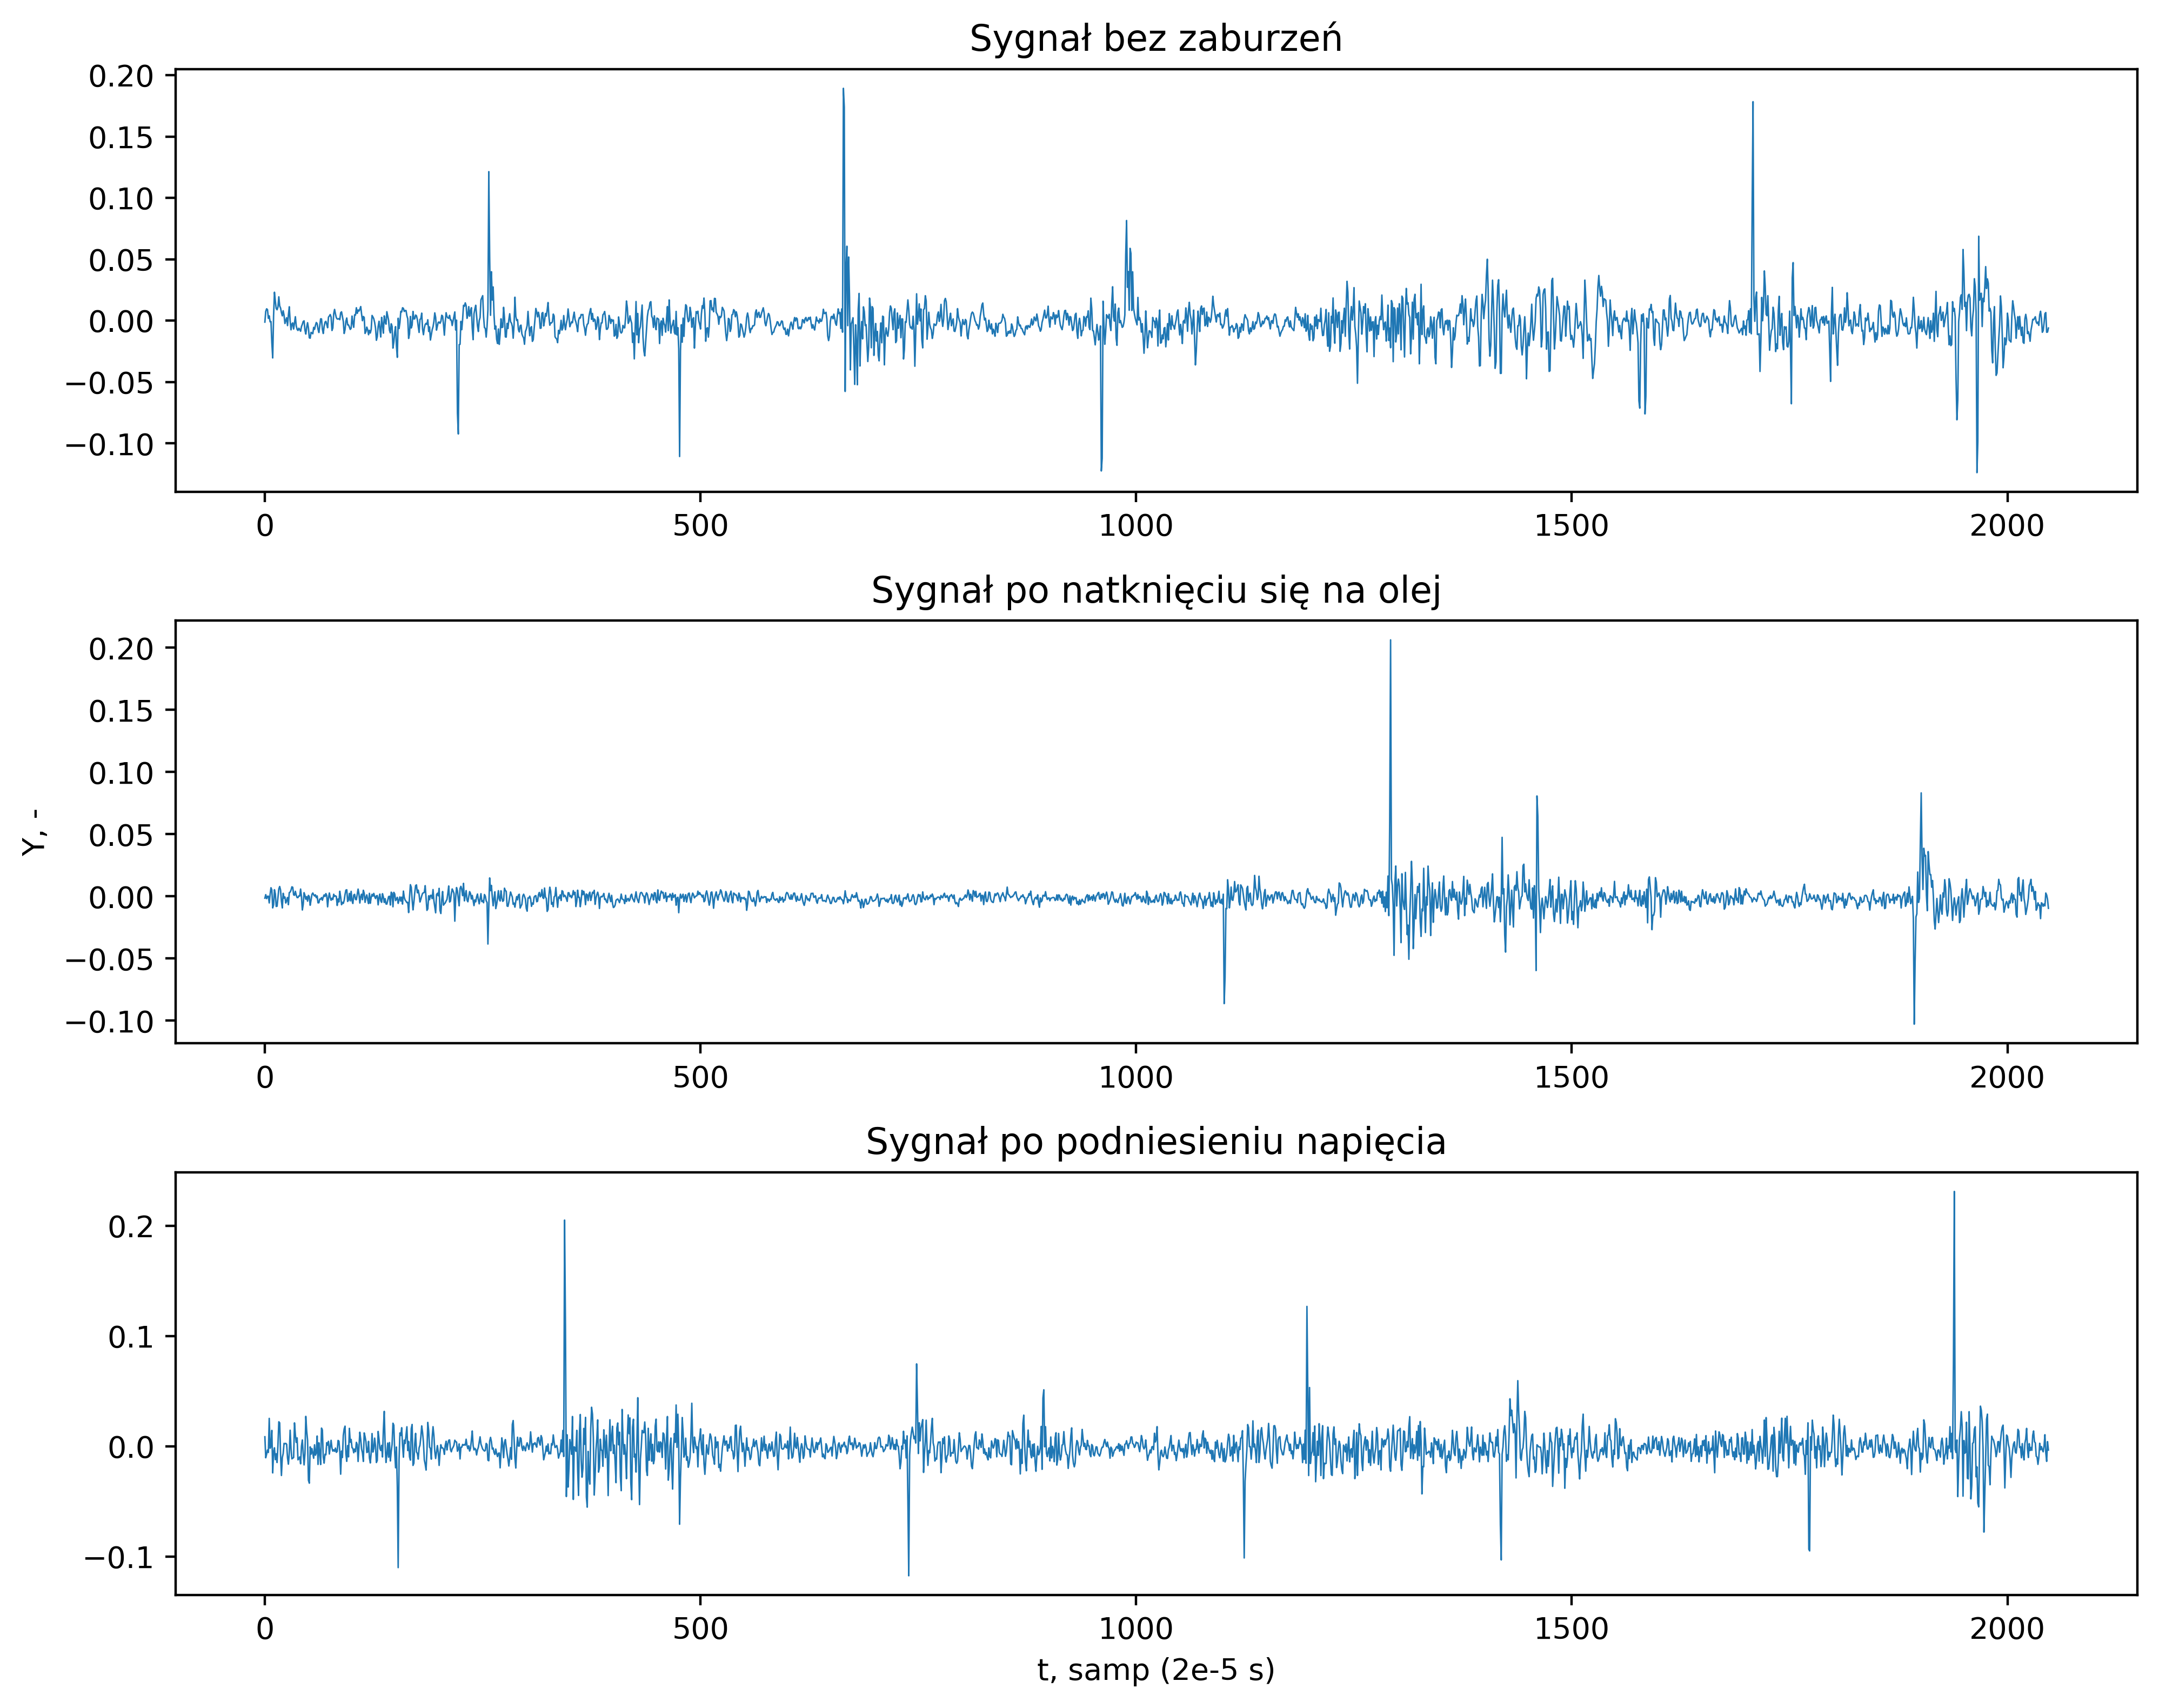

In [80]:
ax[0].set_title("Sygnał bez zaburzeń")
ax[1].set_title("Sygnał po natknięciu się na olej")
ax[2].set_title("Sygnał po podniesieniu napięcia")
ax[2].set_xlabel('t, samp (2e-5 s)');
ax[1].set_ylabel('Y, -')
fig.tight_layout()

fig



In [81]:
fig.savefig("surowy_sygnal.png")

ModuleNotFoundError: No module named 'scipy.stats.beta'

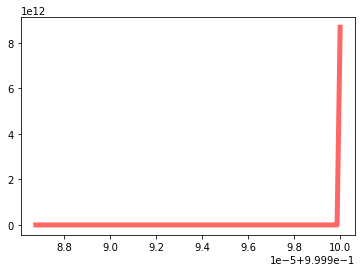

In [88]:
from scipy.stats import beta

import matplotlib.pyplot as plt

a, b = 2.31, 0.001

mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')

fig, ax = plt.subplots(1, 1)
x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)

ax.plot(x, beta.pdf(x, a, b),
       'r-', lw=5, alpha=0.6, label='beta pdf')